Using data from nevena flat line removal

In [109]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
# --- Data Loading ---
directory_path = r'/Users/rprocious/Waterlevels_CBI/CBI-2/nesscan_fixed_removed_flat_lines_03312025/bobHallPier'
dataframes = []
for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(
            file_path,
            parse_dates=[0],
            na_values=[-999, -99, 99, 'NA', 'RM'],
            engine='python'
        )
        df.columns = ['date', 'pwl']
        dataframes.append(df)

bhp = pd.concat(dataframes, ignore_index=True)
bhp['date'] = pd.to_datetime(bhp['date'])
bhp = bhp[bhp['date'] >= pd.to_datetime('1996-01-01')]
bhp = bhp.reset_index(drop=True)

# --- Remove obvious outliers using ±4 from median ---
median_val = bhp['pwl'].median()
bhp.loc[np.abs(bhp['pwl'] - median_val) > 4, 'pwl'] = np.nan


In [110]:

pwl = bhp['pwl']
s = lambda x: pwl.shift(x)

# --- Compute All 8 Third Differences ---
bhp['3DF']    = s(3)  - 3 * s(2)  + 3 * s(1)  - s(0)
bhp['3DFm1']  = s(4)  - 3 * s(3)  + 3 * s(2)  - s(0)
bhp['3DFm2']  = s(4)  - 3 * s(3)  + 3 * s(1)  - s(0)
bhp['3DFm3']  = s(4)  - 3 * s(2)  + 3 * s(1)  - s(0)

bhp['3DB']    = s(-3) - 3 * s(-2) + 3 * s(-1) - s(0)
bhp['3DBm1']  = s(-4) - 3 * s(-3) + 3 * s(-2) - s(0)
bhp['3DBm2']  = s(-4) - 3 * s(-3) + 3 * s(-1) - s(0)
bhp['3DBm3']  = s(-3) - 3 * s(-2) + 3 * s(-1) - s(0)

third_diff_cols = ['3DF', '3DFm1', '3DFm2', '3DFm3', '3DB', '3DBm1', '3DBm2', '3DBm3']
bhp[third_diff_cols] = bhp[third_diff_cols].round(4)

# Flag each 3D if it exceeds ±6 STD
def create_flag_column(df, col):
    std = df[col].std(skipna=True)
    mean = df[col].mean(skipna=True)
    upper = mean + 6 * std
    lower = mean - 6 * std
    return ((df[col] > upper) | (df[col] < lower)).astype(int)

third_diff_flag_cols = [f'{col}_flag' for col in third_diff_cols]
for col in third_diff_cols:
    bhp[f'{col}_flag'] = create_flag_column(bhp, col)

# Create suspect flag
bhp['suspect_flag'] = bhp[third_diff_cols].isna().all(axis=1).astype(int)

# Clean using only the third diff flags (not repeat/spike)
bhp['pwl_cleaned'] = np.where(
    bhp[third_diff_flag_cols].sum(axis=1) > 0,
    np.nan,
    bhp['pwl']
)
bhp.loc[bhp['suspect_flag'] == 1, 'pwl_cleaned'] = np.nan

In [111]:
for col in ['spike_pass', 'spike_repeat_flag', 'spike_flag']:
    if col not in bhp.columns:
        bhp[col] = 0

# Now get all flag columns (excluding suspect)
all_flag_cols = [col for col in bhp.columns if col.endswith('_flag') and col != 'suspect_flag']

# Get rows where any flag is set
flagged_rows = bhp[all_flag_cols].any(axis=1)
flagged_indices = bhp.index[flagged_rows]

for i in flagged_indices:
    spike_val = bhp.at[i, 'pwl']
    pass_val = bhp.at[i, 'spike_pass']
    if pd.isna(spike_val):
        continue

    # Forward
    j = i + 1
    while j < len(bhp) and bhp.at[j, 'pwl'] == spike_val:
        if bhp.loc[j, 'spike_flag'] == 0:
            bhp.at[j, 'spike_repeat_flag'] = 1
            bhp.at[j, 'spike_flag'] = 1
            bhp.at[j, 'spike_pass'] = pass_val
            bhp.at[j, 'pwl_cleaned'] = np.nan
        j += 1

    # Backward
    j = i - 1
    while j >= 0 and bhp.at[j, 'pwl'] == spike_val:
        if bhp.loc[j, 'spike_flag'] == 0:
            bhp.at[j, 'spike_repeat_flag'] = 1
            bhp.at[j, 'spike_flag'] = 1
            bhp.at[j, 'spike_pass'] = pass_val
            bhp.at[j, 'pwl_cleaned'] = np.nan
        j -= 1


# Move pwl_cleaned to end
pwl_cleaned_col = bhp.pop('pwl_cleaned')
bhp['pwl_cleaned'] = pwl_cleaned_col
bhp = bhp.drop(columns=['spike_pass', 'spike_flag'])


Had to change from 5 repeated values after a spike to unlimited values after a spike due to this case of 2.777 6 times

In [130]:
bhp[576620:576670].to_clipboard()

In [113]:
bhp['suspect_flag'].sum() - bhp['pwl'].isna().sum()

306

In [114]:
bhp['spike_repeat_flag'].sum()

149

Text(0, 0.5, 'Freq')

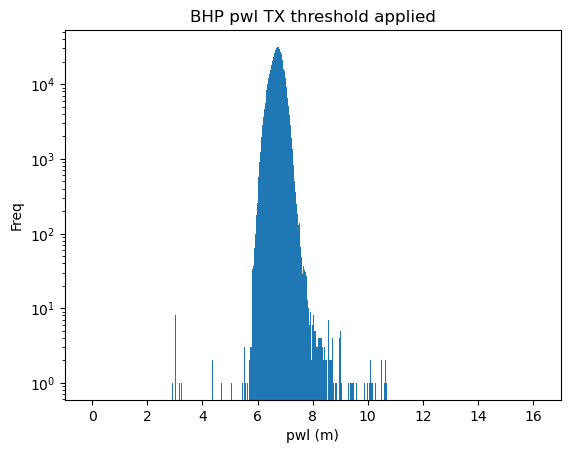

In [115]:
plt.hist(bhp['pwl'],1000)
plt.yscale('log')
plt.xlim(-1,17)
plt.title('BHP pwl TX threshold applied')
plt.xlabel('pwl (m)')
plt.ylabel('Freq')

Text(0, 0.5, 'Freq')

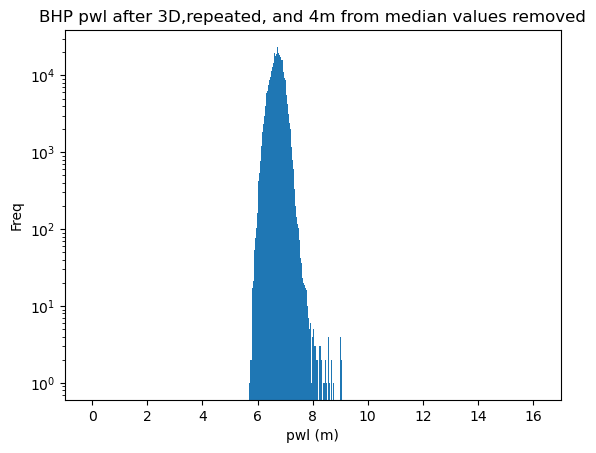

In [116]:
plt.hist(bhp['pwl_cleaned'],1000)
plt.yscale('log')
plt.xlim(-1,17)
plt.title('BHP pwl after 3D,repeated, and 4m from median values removed')
plt.xlabel('pwl (m)')
plt.ylabel('Freq')

In [117]:
bhp['pwl_cleaned'].idxmax()

137206

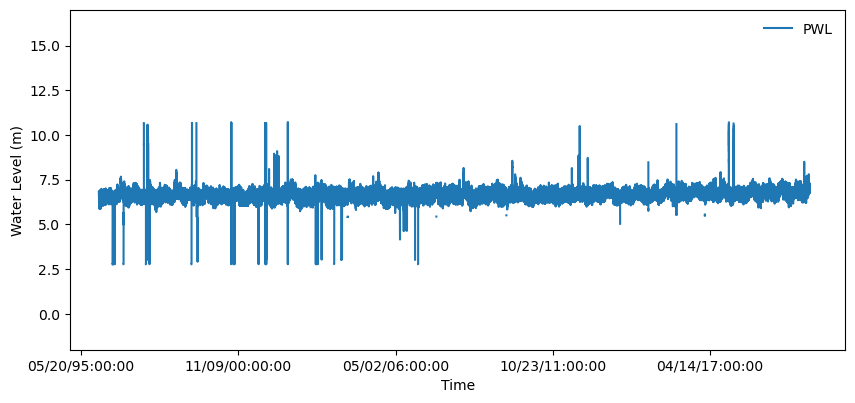

In [118]:
start_date = pd.to_datetime('1995/01/01 00:00')
end_date = pd.to_datetime('2021/12/30 03:30')

# Filter the data to only include the xlim range
filtered_data = bhp[(bhp['date'] >= start_date) & (bhp['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl'], label='PWL')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D:%H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2000))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(-2,17)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()

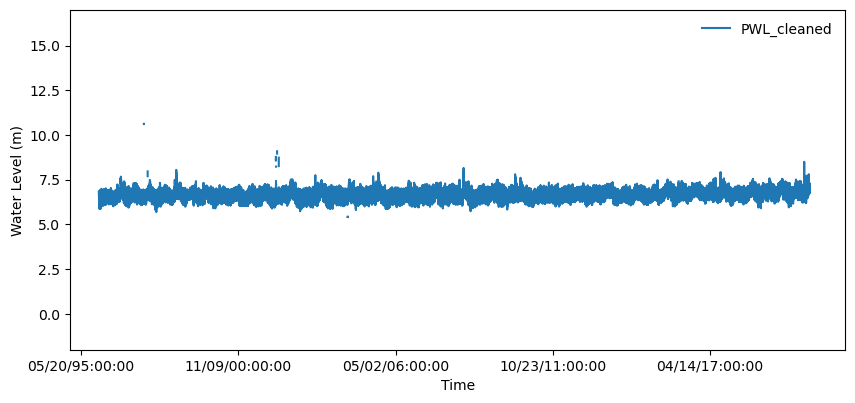

In [119]:
start_date = pd.to_datetime('1995/01/01 00:00')
end_date = pd.to_datetime('2021/12/30 03:30')

# Filter the data to only include the xlim range
filtered_data = bhp[(bhp['date'] >= start_date) & (bhp['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl_cleaned'], label='PWL_cleaned')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D:%H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2000))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(-2,17)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()

Need to find a way to handle the values after a gap, maybe switching to a forward pass at those locations

In [120]:
bhp[41420:41450]

,date,pwl,3DF,3DFm1,3DFm2,3DFm3,3DB,3DBm1,3DBm2,3DBm3,...,3DFm1_flag,3DFm2_flag,3DFm3_flag,3DB_flag,3DBm1_flag,3DBm2_flag,3DBm3_flag,suspect_flag,spike_repeat_flag,pwl_cleaned
41420,1996-06-21 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,NaN
41421,1996-06-21 14:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,NaN
41422,1996-06-21 14:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,NaN
41423,1996-06-21 14:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,NaN
41424,1996-06-21 14:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,NaN
41425,1996-06-21 14:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,NaN
41426,1996-06-21 14:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,NaN
41427,1996-06-21 14:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,NaN
41428,1996-06-21 14:48:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,NaN
41429,1996-06-21 14:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,NaN


In [121]:
bhp['pwl_cleaned'].isna().sum() - bhp['pwl'].isna().sum()

2404

In [129]:
bhp[44340:44370].to_clipboard()

In [132]:
bhp[75043:75083].to_clipboard()

In [124]:
suspects_df = bhp.dropna(subset=['pwl'])

In [125]:
suspects_df['suspect_flag'].sum()

306

In [126]:
for col in ['3DF', '3DFm1', '3DFm2', '3DFm3', '3DB', '3DBm1', '3DBm2', '3DBm3']:
    mean = bhp[col].mean(skipna=True)
    std = bhp[col].std(skipna=True)
    upper = mean + 6 * std
    lower = mean - 6 * std
    print(f"{col}: mean={mean:.4f}, std={std:.4f}, range=({lower:.4f}, {upper:.4f})")


3DF: mean=0.0000, std=0.1025, range=(-0.6148, 0.6148)
3DFm1: mean=-0.0000, std=0.0985, range=(-0.5907, 0.5907)
3DFm2: mean=0.0001, std=0.1004, range=(-0.6022, 0.6023)
3DFm3: mean=-0.0000, std=0.0998, range=(-0.5985, 0.5985)
3DB: mean=-0.0000, std=0.1025, range=(-0.6148, 0.6148)
3DBm1: mean=0.0000, std=0.0998, range=(-0.5985, 0.5985)
3DBm2: mean=-0.0001, std=0.1004, range=(-0.6023, 0.6022)
3DBm3: mean=-0.0000, std=0.1025, range=(-0.6148, 0.6148)


In [127]:
print(bhp.loc[44363, third_diff_flag_cols])


3DF_flag      0
3DFm1_flag    0
3DFm2_flag    0
3DFm3_flag    0
3DB_flag      0
3DBm1_flag    0
3DBm2_flag    0
3DBm3_flag    0
Name: 44363, dtype: object
